In [2]:
import torch
import os,json,sys
sys.path.append(os.path.abspath(".")) 
sys.path.append(os.path.abspath("..")) 
# from torch.utils.data import Dataset
# from transformers import AutoTokenizer,AutoModelForCausalLM
import re
from tqdm import tqdm
# from transformers import AutoTokenizer
from utils.utils import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


/tmp/ipykernel_80216/1262956563.py:51: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_melted[df_melted["Metric"] == metric],
/tmp/ipykernel_80216/1262956563.py:51: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_melted[df_melted["Metric"] == metric],
/tmp/ipykernel_80216/1262956563.py:51: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_melted[df_melted["Metric"] == metric],
/tmp/ipykernel_80216/1262956563.py:51: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=df_melted[df_melted["Metric"] == metric],


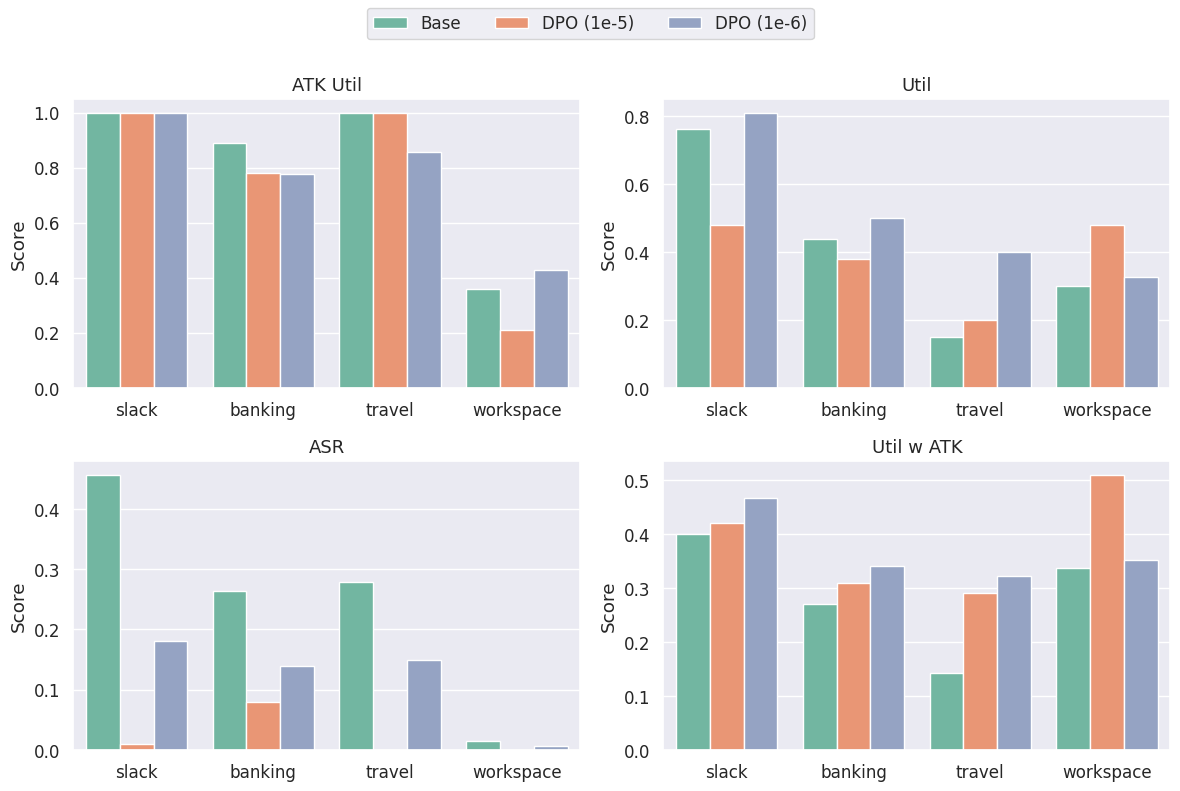

In [5]:
# File mapping
files = {
    "Base": "qwen3_Qwen3-8B.json",
    "DPO (1e-5)": "qwen3_Qwen3-8B_1e-5_MetaSecAlign_DPO.json",
    "DPO (1e-6)": "qwen3_Qwen3-8B_1e-6_MetaSecAlign_DPO.json"
}

# Load all files
data = {}
for label, file in files.items():
    with open(os.path.join('results/agentdojo',file), "r") as f:
        data[label] = json.load(f)

# Function to normalize structure: some files wrap metrics under "mean_results"
def extract_metrics(d):
    if "mean_results" in d:
        return d["mean_results"]
    return d

# Flatten into DataFrame
records = []
for model_name, model_data in data.items():
    metrics = extract_metrics(model_data)
    for env, env_data in metrics.items():
        records.append({
            "Model": model_name,
            "Environment": env,
            "ATK Util": env_data["injection_utility"],
            "Util": env_data["task_utility"],
            "ASR": env_data["asr"],
            "Util w ATK": env_data["attack_utility"]
        })

df = pd.DataFrame(records)

# Melt for seaborn
df_melted = df.melt(id_vars=["Model", "Environment"], 
                    value_vars=["ATK Util", "Util", "ASR", "Util w ATK"],
                    var_name="Metric", value_name="Score")

# Plot setup
sns.set(style="darkgrid", font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)
axes = axes.flatten()

metrics = ["ATK Util", "Util", "ASR", "Util w ATK"]
palette = sns.color_palette("Set2")

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(data=df_melted[df_melted["Metric"] == metric],
                x="Environment", y="Score", hue="Model",
                ax=ax, palette=palette)
    ax.set_title(metric, fontsize=13)
    ax.set_xlabel("")
    ax.set_ylabel("Score")
    ax.legend_.remove()

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [3]:
with open('/export/home2/weijie210/ipi_huawei/aside/data/train_data/toolace_train_parsed.json','r') as f:
    data = json.load(f)
print (len(data))

10141


In [5]:
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-8B')
# model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen3-8B',torch_dtype=torch.float16,device_map='auto').eval()
all_lens = []
for d in tqdm(data,total = len(data)):
    conv = []
    for x in d['conversations']:
        if x['from'] == 'function': # convert to tool
            x['from'] = 'tool'
        conv.append({'role':x['from'],'content':x['value'].lstrip('\n')}) # remove leading \n (ToolLLM have these)

    formatted = tokenizer.apply_chat_template(conv,tokenize=False,add_generation_prompt=False,enable_thinking=False,tools=d['tools'])

    input_ids = tokenizer(formatted, add_special_tokens=False,return_tensors = 'pt',truncation=False)['input_ids'][0]
    all_lens.append(len(input_ids))


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10141/10141 [00:31<00:00, 321.57it/s]


In [1]:
tools = [
    {
        "name":"get_current_temperature",
        "description":"Get the current temperature at a given location",
        "parameters":{
            "type":"object",
            "properties":{
                "location":{"type":"string"}
            },
            "required":["location"]
        }
    },
    {
        "name":"get_temperature_on_date",
        "description":"Get temperature at a location on a given date",
        "parameters":{
            "type":"object",
            "properties":{
                "location":{"type":"string"},
                "date":{"type":"string"}
            },
            "required":["location","date"]
        }
    }
]

messages = [
    {"role":"system", "content":"You are an assistant with access to the tools described below. Use them when needed."},
    {"role":"user", "content":"What is the temperature in London on 2025-09-15?"}
]

prompt = tokenizer.apply_chat_template(
    messages,
    tools=tools,
    enable_thinking=False,  # or False depending
    tokenize=False,
    add_generation_prompt=True,
    # tool_call_parser="hermes"  # if applicable
)

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
output = model.generate(input_ids, max_new_tokens=100)
text = tokenizer.decode(output[0], skip_special_tokens=False)

print(text)

NameError: name 'tokenizer' is not defined

In [48]:
def smart_split(s: str):
    parts, buf, depth = [], "", 0
    for ch in s:
        if ch == "," and depth == 0:
            parts.append(buf.strip())
            buf = ""
        else:
            buf += ch
            if ch in "{[":
                depth += 1
            elif ch in "}]":
                depth -= 1
    if buf.strip():
        parts.append(buf.strip())
    return parts

def parse_label(text):
    bracket_match = re.search(r"\[(.*)\]", text, re.DOTALL)
    if not bracket_match:
        return None

    calls_str = bracket_match.group(1)
    # safer split: keep ) but trim whitespace
    raw_calls = [c.strip() for c in re.split(r"\)\s*,", calls_str) if c.strip()] # incase multiple function, return the one that parses correctly
    if not len(raw_calls):
        return None
    parsed = []
    
    for call in raw_calls:
        if not call.endswith(")"):
            call += ")"
        func_match = re.match(r"^(.*?)\((.*)\)$", call.strip())
        if not func_match:
            continue
        function_name, params_str = func_match.groups()
        # strip final ) if present
        params_str = params_str.strip()
        if params_str.endswith(")"):
            params_str = params_str[:-1]

        params = {}
        for pair in smart_split(params_str):
            if "=" not in pair:
                continue
            k, v = pair.split("=", 1)
            k, v = k.strip(), v.strip()

            # clean trailing )
            v = v.rstrip(")")
            try:
                v_parsed = json.loads(v)
            except Exception:
                v_parsed = v.strip('"').strip("'")
            params[k] = v_parsed
        params = str(params).replace("'",'"')
        try:
            params_dict = json.loads(params)
            parsed_str = str(({'name': function_name.strip(), 'arguments': params_dict})).replace("'",'"')
            parsed_str = f"<tool_call>\n{parsed_str}\n</tool_call>"
            parsed.append(parsed_str)
        except Exception:
            continue
    return parsed if len(parsed) else None

In [49]:
parsed_ds = []
pre_ = 'Here is a list of functions in JSON format that you can invoke:'
post_ = 'Should you decide to return the function call(s).'

for d in data:
    sys = d['system']
    tools = sys.split(pre_)[-1].split(post_)[0].strip()
    if tools.endswith('.'):
        tools = tools[:-1]
    try:
        d['tools'] = json.loads(tools)
    except Exception:
        continue
    skip=False
    for conv in d['conversations']:
        if conv['from'] == 'assistant':
            if conv['value'].startswith('[') and conv['value'].endswith(']'):
                label = conv['value']
                parsed = parse_label(label)
                parsed = '\n'.join(parsed) if parsed else None
                conv['value'] = parsed
                if parsed is None:
                    skip = True
    if not skip:
        parsed_ds.append(d)
print (len(parsed_ds), len(data))

469 500


In [50]:
with open('/export/home2/weijie210/ipi_huawei/aside/data/train_data/toolace_val_parsed.json','w') as f:
    json.dump(parsed_ds, f, indent=4)

In [12]:
train_dataset = ToolDataset(data[10:], tokenizer, max_length=4096)

In [14]:
# print ([v['from'] for v in data[10]['conversations']])
for i in train_dataset:
    pprint (tokenizer.decode(i['input_ids']))
    label_chunks = []
    s = False

    for j,v in enumerate(i['segment_ids']):
        if not s and v != 0:
            s = True
            label_chunks.append([])
        if s and v != 0:
            label_chunks[-1].append(i['input_ids'][j])
        if s and v == 0:
            s = False
    # print (label_chunks)
    for lc in label_chunks:
        pprint (tokenizer.decode(lc))
    break

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ <|im_start|>system                                                                               │
│ You are an expert in composing functions. You are given a question and a set of possible         │
│ functions.                                                                                       │
│ Based on the question, you will need to make one or more function/tool calls to achieve the      │
│ purpose.                                                                                         │
│ If none of the function can be used, point it out. If the given question lacks the parameters    │
│ required by the function,                                                                        │
│ also point it out.                                                                               │
│ Today is 2023-04-21, Friday..Here is a list of functions in JSON format that you can invoke:     │
│ [{"name": "public_speaking_improvement_suggestion", "description": "Provide suggestions for      │
│ improving public speaking techniques.", "parameters": {"type": "dict", "properties":             │
│ {"speech_duration": {"type": "int", "description": "The duration of the speech in minutes."},    │
│ "audience_feedback": {"type": "array", "description": "List of audience feedback.", "items":     │
│ {"type": "dict", "properties": {"feedback_content": {"type": "string", "description": "Content   │
│ of the feedback."}, "feedback_time": {"type": "string", "enum": ["Morning", "Afternoon",         │
│ "Evening"], "description": "Time when the feedback was given.", "default": "Morning"}},          │
│ "required": ["feedback_content"]}}}, "required": ["speech_duration"]}, "required": null},        │
│ {"name": "public_speaking_assessment", "description": "Assess the effectiveness of public        │
│ speaking techniques.", "parameters": {"type": "dict", "properties": {"speech_content": {"type":  │
│ "string", "description": "The content of the speech."}, "techniques": {"type": "array",          │
│ "description": "List of public speaking techniques used.", "items": {"type": "dict",             │
│ "properties": {"technique_name": {"type": "string", "description": "Name of the technique."},    │
│ "usage_time": {"type": "string", "enum": ["Beginning", "Middle", "End"], "description": "When    │
│ the technique was used during the speech.", "default": "Beginning"}}, "required":                │
│ ["technique_name"]}}}, "required": ["speech_content"]}, "required": null}].                      │
│ Should you decide to return the function call(s).                                                │
│ Put it in the format of                                                                          │
│                                                                                                  │
│ NO other text MUST be included.                                                                  │
│ <|im_end|>                                                                                       │
│ <|im_start|>user                                                                                 │
│ I recently gave a 30-minute presentation at a conference. I used storytelling in the beginning,  │
│ rhetorical questions in the middle, and a powerful quote to conclude. I received mixed feedback  │
│ from the audience throughout the day. Can you first assess my speech effectiveness using these   │
│ techniques, and based on the results, provide suggestions to improve my public                   │
│ speaking?<|im_end|>                                                                              │
│ <|im_start|>assistant                                                                            │
│ [public_speaking_assessment(speech_content="Storytelling in the beginning, rhetorical questions  │
│ in the middle, and a powerful quote to conclude", technique

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│ [{"name": "public_speaking_assessment", "results": {"assessment_result": "Effective use of       │
│ techniques but could benefit from better integration and timing adjustments."}}]                 │
│ </tool_response>                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│ [{"name": "public_speaking_improvement_suggestion", "results": {"improvement_suggestion": "Focus │
│ on weaving storytelling more directly into the core message. Use rhetorical questions sparingly  │
│ to maintain impact. Ensure concluding quotes directly reinforce the speech's main points."}}]    │
│ </tool_response>                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

In [1]:
from transformers import TrainingArguments

# Create a dummy instance (with minimal required args)
args = TrainingArguments(output_dir="out")

# Inspect the help / schema of TrainingArguments
print(TrainingArguments.__annotations__.keys())  # shows all fields
print(args.save_strategy)

dict_keys(['output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_backend